https://www.kaggle.com/datasets/msambare/fer2013

# 1. Load Dependency

## 1.1 Load Code from Github

In [7]:
#rm -rf Data_Mining
!git clone https://github.com/VinceTruong/Data_Mining.git

Cloning into 'Data_Mining'...
remote: Enumerating objects: 45082, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 45082 (delta 4), reused 8 (delta 2), pack-reused 45070
Receiving objects: 100% (45082/45082), 62.37 MiB | 30.81 MiB/s, done.
Resolving deltas: 100% (112/112), done.
Updating files: 100% (115850/115850), done.


## 1.2 Load necessaty tools and libraries

In [37]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform

from keras.models import Sequential
from keras import regularizers
from keras.layers import RandomZoom, AveragePooling2D, Add, Dense, Conv2D, MaxPool2D , Flatten, Dropout, BatchNormalization, Input, ZeroPadding2D, Activation, MaxPooling2D

import warnings
warnings.filterwarnings("ignore")

In [9]:
train_path = "Data_Mining/dataset_aug/train"
test_ds = "Data_Mining/dataset_aug/test"

# 2. Load and explore dataset

## 2.1 General Exploration

In [10]:
os.listdir(train_path) # 7 categories

['disgust', 'happy', 'neutral', 'fear', 'surprise', 'sad', 'angry']

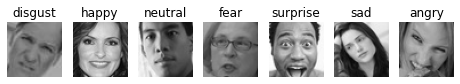

In [11]:
# explore the image and labels
i = 1
plt.figure(figsize=(8,8))
for expression in os.listdir(train_path):
    img = load_img((train_path +'/'+ expression +'/'+ os.listdir(train_path + '/' + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
    
plt.show()

## 2.2 Train - Validation - Test Split

In [12]:
# The data consists of 48x48 pixel grayscale images of faces.
batch_size = 256
img_height = 48
img_width = 48

In [13]:
# Load train, validation, test from directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = train_path,
    labels = "inferred",
    validation_split = 0.2,
    subset = 'training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode="categorical")

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory = train_path,
    labels = "inferred",
    validation_split = 0.2,
    subset = 'validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode="categorical")

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory = test_ds,
    labels = "inferred",
    seed=123,
    image_size=(img_height, img_width),
    #batch_size=batch_size,
    color_mode='grayscale',
    label_mode="categorical")

Found 31970 files belonging to 7 classes.
Using 25576 files for training.


2022-12-06 01:37:48.703501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 01:37:48.707724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 01:37:48.708451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 01:37:48.711247: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 31970 files belonging to 7 classes.
Using 6394 files for validation.
Found 7101 files belonging to 7 classes.


## 2.3 Normalize dataset

In [15]:
train_ds_normal = train_ds.map(lambda x,y: (x/255, y))
val_ds_normal = val_ds.map(lambda x,y: (x/255, y))
test_ds_normal = test_ds.map(lambda x,y: (x/255, y))

In [16]:
#train dataset
trainX, trainY = zip(*train_ds)
trainX = np.concatenate([x for x in trainX], axis = 0)
trainY = np.concatenate([y for y in trainY], axis = 0)
#validation dataset
valX, valY = tuple(zip(*val_ds))
valX = np.concatenate([x for x in valX], axis = 0)
valY = np.concatenate([y for y in valY], axis = 0)
#test datasett
testX, testY = tuple(zip(*test_ds))
testX = np.concatenate([x for x in testX], axis = 0)
testY = np.concatenate([y for y in testY], axis = 0)

2022-12-06 01:38:00.121154: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [17]:
print(trainX.shape)
print(trainY.shape)

print(valX.shape)
print(valY.shape)

print(testX.shape)
print(testY.shape)

(25576, 48, 48, 1)
(25576, 7)
(6394, 48, 48, 1)
(6394, 7)
(7101, 48, 48, 1)
(7101, 7)


disgust


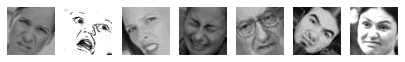

happy


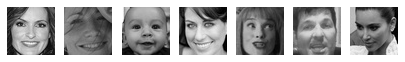

neutral


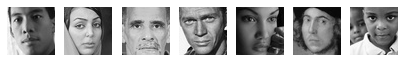

fear


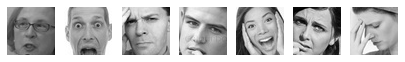

surprise


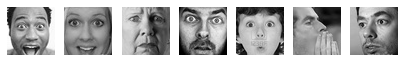

sad


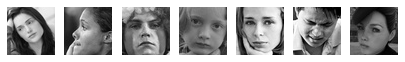

angry


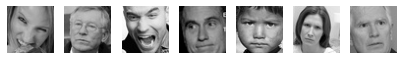

In [18]:
# Explore 7 data samples for each category
i = 1
for expression in os.listdir(train_path):
    plt.figure(figsize=(7,7))
    print(expression)
    for j in range(1, 8):
        img = load_img((train_path +'/'+ expression +'/'+ os.listdir(train_path + '/' + expression)[j]))
        plt.subplot(i,7,j)
        plt.imshow(img)
        plt.axis('off')
    i += 1
    plt.show()

## 2.4 Visualisation

In [19]:
train_category = list(np.sum(trainY, axis=0).astype('int64'))
print(train_category)

[3188, 3098, 3276, 5716, 3924, 3857, 2517]


In [20]:
test_category = list(np.sum(testY, axis=0).astype('int64'))
print(test_category)

[944, 108, 1007, 1759, 1223, 1234, 826]


In [21]:
train_category.sort(reverse=True)
facial = ['happy', 'neutral', 'sad', 'fear', 'angry', 'disgust','surprise']

#print(category)
dic_train = {facial[i]: train_category[i] for i in range(7)}
print(dic_train)

{'happy': 5716, 'neutral': 3924, 'sad': 3857, 'fear': 3276, 'angry': 3188, 'disgust': 3098, 'surprise': 2517}


In [22]:
test_category.sort(reverse=True)

#print(category)
dic_test = {facial[i]: test_category[i] for i in range(7)}
print(dic_test)

{'happy': 1759, 'neutral': 1234, 'sad': 1223, 'fear': 1007, 'angry': 944, 'disgust': 826, 'surprise': 108}


In [23]:
#Training set
fig = go.Figure(data=[go.Bar(x=list(dic_train.keys()), 
                              y=list(dic_train.values()))])
fig

In [24]:
#Test set
fig = go.Figure(data=[go.Bar(x=list(dic_test.keys()), 
                              y=list(dic_test.values()))])
fig

# 3. Best Model


## 3.1 Define some Plot functions

In [25]:
y_test = np.argmax(testY, axis = 1)

In [26]:
args = {
    "epochs": 20,
    "batches": 256,
    "lr": 0.0001
}
adm = Adam(learning_rate=args["lr"])

In [27]:
# roc_curve definition
def plot_multiclass_roc(y_predict, y_test):

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    
    for i in range(7):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_predict[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=(10,10))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(7):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], test_ds.class_names[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

#plot_multiclass_roc()

In [28]:
# confustion matrix for model result
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap = 'Blues')
    sns.set(rc={'figure.figsize':(10, 10)})
    sns.set(font_scale=1.4)
    ax.set_title('Confusion matrix of action recognition for ' + ds_type)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
labels = ['angry', 'digust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

## 3.2 VGG16

VGG16 is convolutional neutral network introduced by K. Simonyan and A. Zisserman, who won a ILSVR(Imagenet) competition in 2014. 

Instead of using large number of hyper-parameter, it feature is using convolution layer of 3x3 filter with stride 1 and same padding, along with maxpool layer of 2x2 filter of stride 2.  

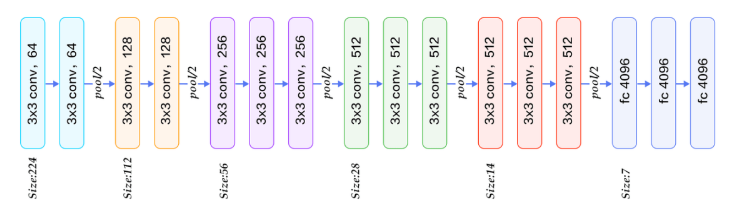

In [38]:
# Creating model
VGG = Sequential()

# 2 x convolution layer of 64 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(input_shape=((48, 48, 1)),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
VGG.add(RandomZoom(0.2, 0.3))
VGG.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# 2 x convolution layer of 128 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# 3 x convolution layer of 256 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# 3 x convolution layer of 512 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# 3 x convolution layer of 512 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# After several convolution layers and pooling layer, data has been flatten and loaded into fully connected layer
# 2 x Dense layers of 4096 units  +  1 x Dense Softmax layer of 7 units
VGG.add(Flatten())
VGG.add(Dense(units=4096,activation="relu"))
VGG.add(Dense(units=4096,activation="relu"))
VGG.add(Dense(units=7, activation="softmax"))

In [30]:
VGG.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 256)       2

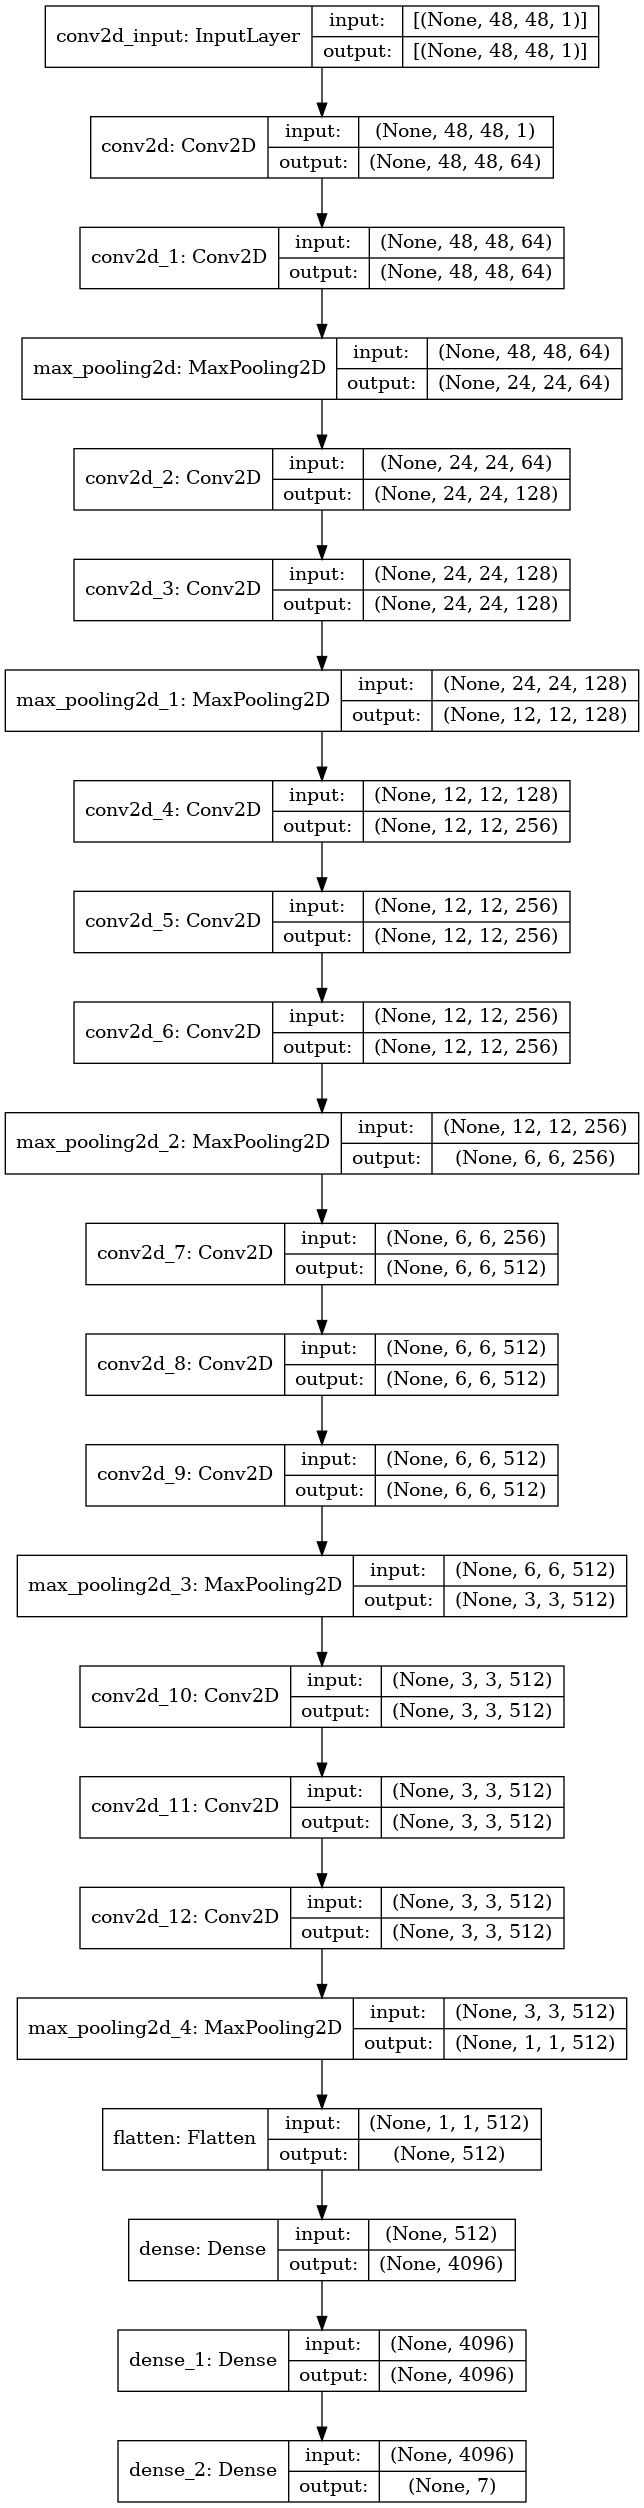

In [31]:
plot_model(VGG, show_shapes=True, show_layer_names=True)

In [39]:
# Saving Checkpoint 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1))

check_point = ModelCheckpoint(filepath='VGG.hdf5', monitor='val_loss', save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

callbacks = [reduce_lr, check_point, early_stop]


[INFO] training network...
Epoch 1/20


2022-12-06 01:49:00.012906: I tensorflow/core/util/cuda_solvers.cc:180] Creating CudaSolver handles for stream 0x5599f2094060


100/100 [==============================] - 15s 128ms/step - loss: 1.8815 - accuracy: 0.2408 - val_loss: 1.7823 - val_accuracy: 0.3266
Epoch 2/20
100/100 [==============================] - 12s 124ms/step - loss: 1.6890 - accuracy: 0.3448 - val_loss: 1.5445 - val_accuracy: 0.4129
Epoch 3/20
100/100 [==============================] - 12s 125ms/step - loss: 1.5139 - accuracy: 0.4277 - val_loss: 1.3807 - val_accuracy: 0.4753
Epoch 4/20
100/100 [==============================] - 12s 125ms/step - loss: 1.3778 - accuracy: 0.4797 - val_loss: 1.3218 - val_accuracy: 0.4966
Epoch 5/20
100/100 [==============================] - 12s 125ms/step - loss: 1.2809 - accuracy: 0.5150 - val_loss: 1.2263 - val_accuracy: 0.5316
Epoch 6/20
100/100 [==============================] - 12s 124ms/step - loss: 1.2099 - accuracy: 0.5396 - val_loss: 1.1559 - val_accuracy: 0.5679
Epoch 7/20
100/100 [==============================] - 12s 125ms/step - loss: 1.1424 - accuracy: 0.5662 - val_loss: 1.1512 - val_accuracy: 0.5

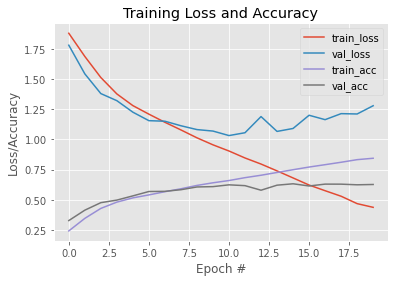

In [40]:
# timing the training process
tic = time.perf_counter()    # start timer
# train the model using SGD
print("[INFO] training network...")
sgd = SGD(learning_rate=args["lr"], momentum=0.9, nesterov=True)
adm = Adam(learning_rate=args["lr"])
VGG.compile(loss="categorical_crossentropy", optimizer=adm, metrics=["accuracy"])

H = VGG.fit(x = trainX, y= trainY, validation_data=(valX, valY), epochs=args["epochs"], batch_size=args["batches"], callbacks=callbacks)

toc = time.perf_counter()    # stop timer
print(f"\n[INFO] Training completed in {(toc - tic)/60:0.4f} minutes\n")


# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, args["epochs"]), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, args["epochs"]), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, args["epochs"]), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, args["epochs"]), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
# plt.savefig(args["output"])

In [41]:
y_predict_vgg = VGG.predict(testX)
y_predict_vgg_label = np.argmax(y_predict_vgg, axis = 1)

In [42]:
accuracy_score(y_test, y_predict_vgg_label)

0.5838614279678919

In [43]:
print(classification_report(y_test, y_predict_vgg_label, target_names = labels))

              precision    recall  f1-score   support

       angry       0.43      0.55      0.48       944
      digust       0.45      0.61      0.52       108
        fear       0.42      0.39      0.40      1007
       happy       0.83      0.79      0.81      1759
     neutral       0.56      0.51      0.53      1223
         sad       0.45      0.44      0.45      1234
    surprise       0.74      0.75      0.75       826

    accuracy                           0.58      7101
   macro avg       0.55      0.58      0.56      7101
weighted avg       0.59      0.58      0.59      7101



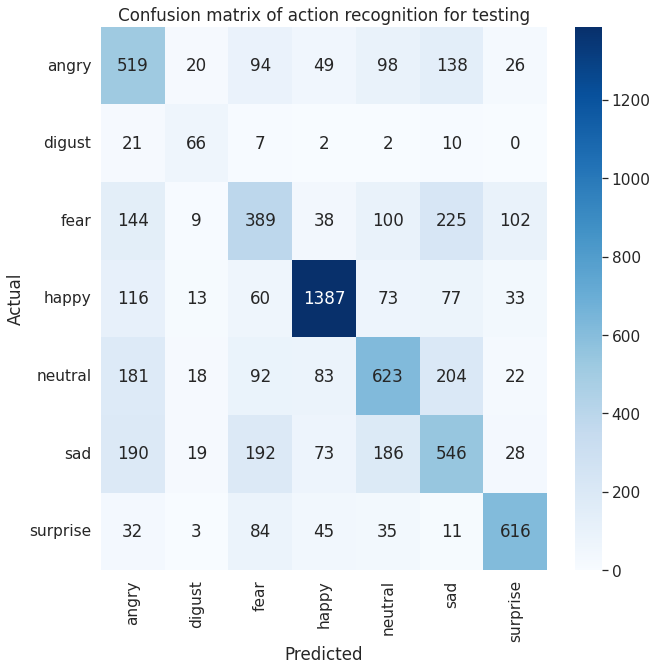

In [46]:
plot_confusion_matrix(y_test, y_predict_vgg_label, labels, 'testing')

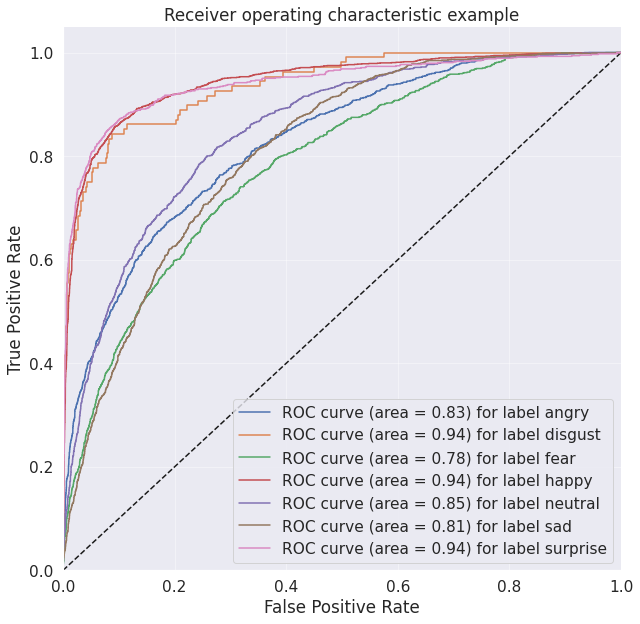

In [47]:
plot_multiclass_roc(y_predict_vgg, testY)